In [26]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
df = pd.read_csv("../results/clean_df.csv")

In [33]:
df['dataset'] = df['dataset'].replace({
    'UCI Digits': 'Optical',
    'Pen Digits': 'Pen'
})
print(df)

     dataset               model  seed    split  train_accuracy  \
0    Semeion  LogisticRegression    42  0.2/0.8        1.000000   
1    Semeion  LogisticRegression    43  0.2/0.8        1.000000   
2    Semeion  LogisticRegression    44  0.2/0.8        1.000000   
3    Semeion  LogisticRegression    42  0.5/0.5        1.000000   
4    Semeion  LogisticRegression    43  0.5/0.5        1.000000   
..       ...                 ...   ...      ...             ...   
103    MNIST                 SVM    43  0.5/0.5        0.988057   
104    MNIST                 SVM    44  0.5/0.5        0.988200   
105    MNIST                 SVM    42  0.8/0.2        0.987339   
106    MNIST                 SVM    43  0.8/0.2        0.987321   
107    MNIST                 SVM    44  0.8/0.2        0.987536   

     validation_accuracy  test_accuracy      C  \
0               0.965409       0.975686  10.00   
1               0.965409       0.959216  10.00   
2               0.968553       0.969412  10.0

1. hyperparameters

In [34]:
param_df = df[['dataset', 'model', 'split', 'C', 'cv_mean_scores', 'cv_std_scores',
                         'train_accuracy', 'validation_accuracy', 'test_accuracy']].copy()

param_df['dataset'] = param_df['dataset'].replace({
    'UCI Digits': 'Optical',
    'Pen Digits': 'Pen'
})

def mean_cv(s):
    if isinstance(s, str):
        numbers = [float(x) for x in s.strip('[]').split()]
        return np.mean(numbers)
    return np.nan
param_df['CV_Mean'] = param_df['cv_mean_scores'].apply(mean_cv)
param_df['CV_Std'] = param_df['cv_std_scores'].apply(mean_cv)

param_df = param_df.groupby(['dataset', 'model', 'split']).agg({
    'C': 'first',
    'CV_Mean': 'mean',
    'CV_Std': 'mean'
}).reset_index()
print(param_df)

    dataset               model    split      C   CV_Mean    CV_Std
0     MNIST        DecisionTree  0.2/0.8    NaN  0.962714  0.003842
1     MNIST        DecisionTree  0.5/0.5    NaN  0.962038  0.002201
2     MNIST        DecisionTree  0.8/0.2    NaN  0.962446  0.001117
3     MNIST  LogisticRegression  0.2/0.8   0.01  0.977591  0.001494
4     MNIST  LogisticRegression  0.5/0.5   0.01  0.981330  0.000583
5     MNIST  LogisticRegression  0.8/0.2   0.01  0.982480  0.000592
6     MNIST                 SVM  0.2/0.8   0.01  0.975572  0.001767
7     MNIST                 SVM  0.5/0.5   0.01  0.981899  0.000611
8     MNIST                 SVM  0.8/0.2   0.01  0.983227  0.000558
9   Optical        DecisionTree  0.2/0.8    NaN  0.946164  0.013252
10  Optical        DecisionTree  0.5/0.5    NaN  0.962877  0.011065
11  Optical        DecisionTree  0.8/0.2    NaN  0.968453  0.008212
12  Optical  LogisticRegression  0.2/0.8  10.00  0.962856  0.005632
13  Optical  LogisticRegression  0.5/0.5  10.00 

In [35]:
report_df = param_df[['model', 'dataset', 'split', 'C', 'CV_Mean', 'CV_Std']].copy()

report_df['CV_Mean'] = report_df['CV_Mean'].round(4)
report_df['CV_Std'] = report_df['CV_Std'].round(4)

report_df['CV'] = report_df['CV_Mean'].astype(str) + " ± " + report_df['CV_Std'].astype(str)

report_df = report_df.drop(columns=['CV_Mean', 'CV_Std'])

report_df = report_df.sort_values(by=['model', 'dataset', 'split']).reset_index(drop=True)

print(report_df)

                 model  dataset    split      C               CV
0         DecisionTree    MNIST  0.2/0.8    NaN  0.9627 ± 0.0038
1         DecisionTree    MNIST  0.5/0.5    NaN   0.962 ± 0.0022
2         DecisionTree    MNIST  0.8/0.2    NaN  0.9624 ± 0.0011
3         DecisionTree  Optical  0.2/0.8    NaN  0.9462 ± 0.0133
4         DecisionTree  Optical  0.5/0.5    NaN  0.9629 ± 0.0111
5         DecisionTree  Optical  0.8/0.2    NaN  0.9685 ± 0.0082
6         DecisionTree      Pen  0.2/0.8    NaN  0.9763 ± 0.0043
7         DecisionTree      Pen  0.5/0.5    NaN   0.978 ± 0.0022
8         DecisionTree      Pen  0.8/0.2    NaN  0.9779 ± 0.0012
9         DecisionTree  Semeion  0.2/0.8    NaN  0.9067 ± 0.0239
10        DecisionTree  Semeion  0.5/0.5    NaN   0.925 ± 0.0192
11        DecisionTree  Semeion  0.8/0.2    NaN  0.9296 ± 0.0099
12  LogisticRegression    MNIST  0.2/0.8   0.01  0.9776 ± 0.0015
13  LogisticRegression    MNIST  0.5/0.5   0.01  0.9813 ± 0.0006
14  LogisticRegression   

heatmap for best cv_mean per model/dataset/split

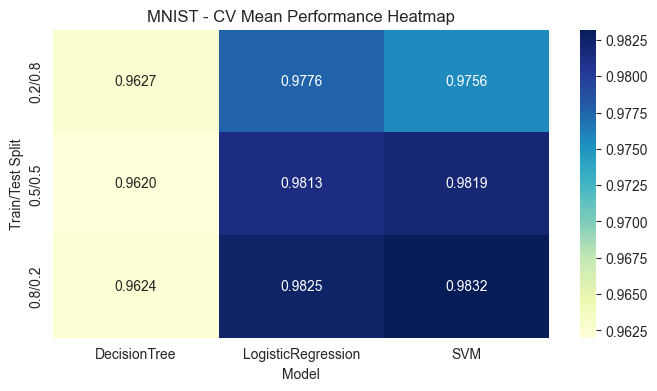

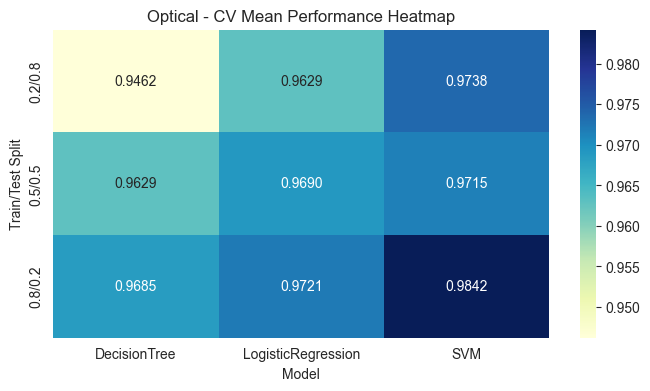

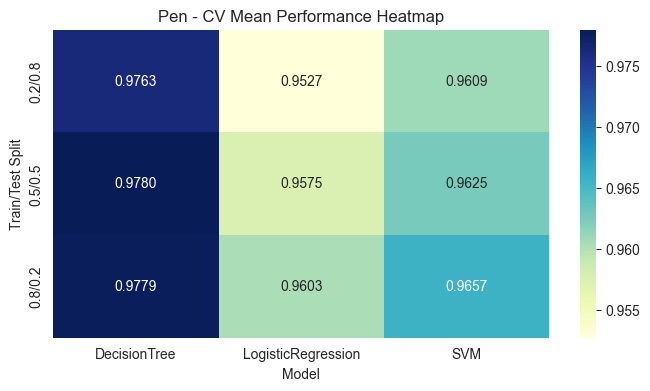

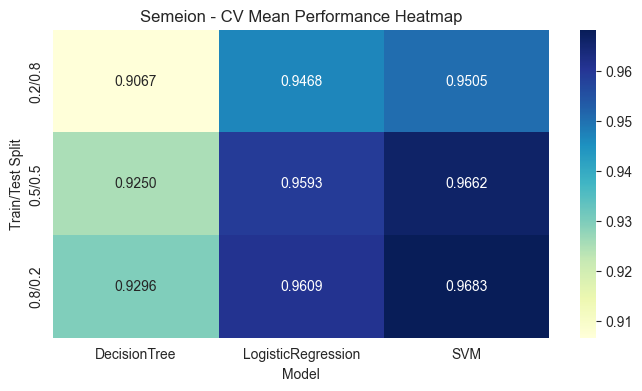

In [36]:
param_df['CV_Mean_Rounded'] = param_df['CV_Mean'].round(4)

save_dir = "../results/plots/cv_heatmaps"
os.makedirs(save_dir, exist_ok=True)

for dataset in param_df['dataset'].unique():
    df_dataset = param_df[param_df['dataset'] == dataset]

    heatmap_data = df_dataset.pivot(index='split', columns='model', values='CV_Mean_Rounded')

    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f"{dataset} - CV Mean Performance Heatmap")
    plt.ylabel("Train/Test Split")
    plt.xlabel("Model")
    filename = f"{dataset.replace(' ', '_')}_heatmap.png"
    plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    plt.show()
    plt.close()

2. accuracies

In [38]:
# test accuracy
mean_acc = df.groupby(['split', 'dataset', 'model'])['test_accuracy'].mean().reset_index()
splits = mean_acc['split'].unique()
tables = {}
for s in splits:
    pivot = mean_acc[mean_acc['split'] == s].pivot(index='model', columns='dataset', values='test_accuracy')
    pivot = pivot.round(3)
    tables[s] = pivot
    print(f"=== Split {s} ===")
    print(pivot)
    print("\n")


=== Split 0.2/0.8 ===
dataset             MNIST  Optical    Pen  Semeion
model                                             
DecisionTree        0.964    0.958  0.976    0.911
LogisticRegression  0.982    0.991  0.979    0.968
SVM                 0.983    0.988  0.981    0.970


=== Split 0.5/0.5 ===
dataset             MNIST  Optical    Pen  Semeion
model                                             
DecisionTree        0.963    0.969  0.981    0.921
LogisticRegression  0.984    0.992  0.982    0.980
SVM                 0.984    0.993  0.983    0.979


=== Split 0.8/0.2 ===
dataset             MNIST  Optical    Pen  Semeion
model                                             
DecisionTree        0.963    0.977  0.979    0.947
LogisticRegression  0.984    0.991  0.982    0.983
SVM                 0.984    0.993  0.983    0.984




In [43]:
mean_acc = df.groupby(['split', 'dataset', 'model'])[['train_accuracy', 'validation_accuracy']].mean().reset_index()
splits = mean_acc['split'].unique()
tables = {}
for s in splits:
    split_df = mean_acc[mean_acc['split'] == s].copy()
    split_df['train_col'] = split_df['dataset'] + '_train'
    split_df['val_col'] = split_df['dataset'] + '_val'
    train_pivot = split_df.pivot(index='model', columns='train_col', values='train_accuracy')
    val_pivot = split_df.pivot(index='model', columns='val_col', values='validation_accuracy')
    pivot = pd.concat([train_pivot, val_pivot], axis=1)
    pivot = pivot[sorted(pivot.columns)]
    pivot = pivot.round(3)
    tables[s] = pivot
    print(f"=== Split {s} ===")
    print(pivot)
    print("\n")

=== Split 0.2/0.8 ===
                    MNIST_train  MNIST_val  Optical_train  Optical_val  \
model                                                                    
DecisionTree              0.969      0.963          1.000        0.946   
LogisticRegression        0.987      0.982          1.000        0.993   
SVM                       0.988      0.982          0.996        0.992   

                    Pen_train  Pen_val  Semeion_train  Semeion_val  
model                                                               
DecisionTree            0.991    0.976          0.988        0.907  
LogisticRegression      0.983    0.980          1.000        0.966  
SVM                     0.984    0.981          0.996        0.968  


=== Split 0.5/0.5 ===
                    MNIST_train  MNIST_val  Optical_train  Optical_val  \
model                                                                    
DecisionTree              0.967      0.962          0.997        0.963   
LogisticRegressi

3. Overfitting

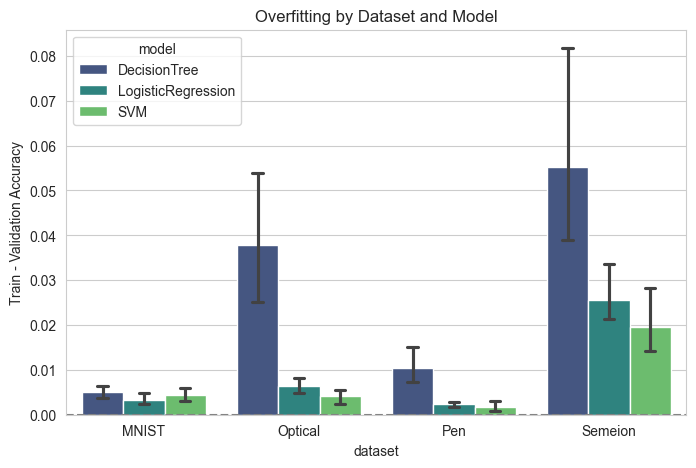

In [69]:
save_dir = "../results/plots"
os.makedirs(save_dir, exist_ok=True)

numeric_cols = df.select_dtypes(include='number').columns

df_of = df.groupby(['dataset', 'model', 'split'])[numeric_cols].mean().reset_index()
df_of['overfit'] = df_of['train_accuracy'] - df_of['validation_accuracy']
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_of,
    x='dataset',
    y='overfit',
    hue='model',
    capsize=0.2,
    palette='viridis'
)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Train - Validation Accuracy")
plt.title("Overfitting by Dataset and Model")
filename = "overfitting.png"
plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
plt.show()
plt.close()

4. Dataset difficulty

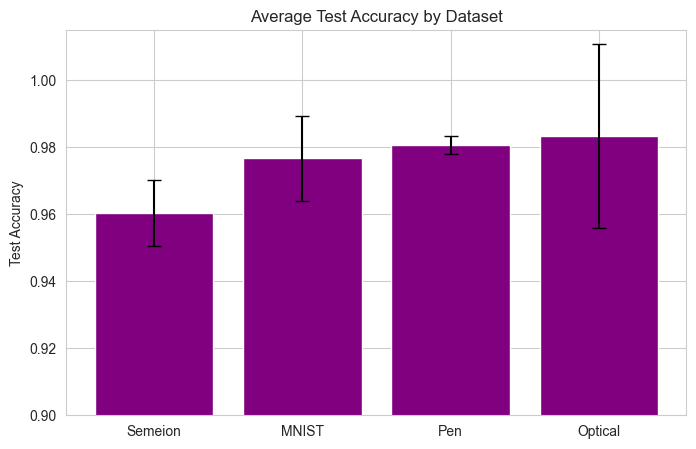

In [61]:
save_dir = "../results/plots"
os.makedirs(save_dir, exist_ok=True)

dataset_avg = df.groupby('dataset')['test_accuracy'].mean().sort_values()
dataset_std = df.groupby('dataset')['test_accuracy'].std()

plt.figure(figsize=(8,5))
plt.bar(
    dataset_avg.index,
    dataset_avg.values,
    yerr=dataset_std.values,
    capsize=5,
    color='purple'
)
plt.ylabel("Test Accuracy")
plt.ylim(0.9, 1.015)
plt.title("Average Test Accuracy by Dataset")
filename = "accuracy_dataset.png"
plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
plt.show()
plt.close()


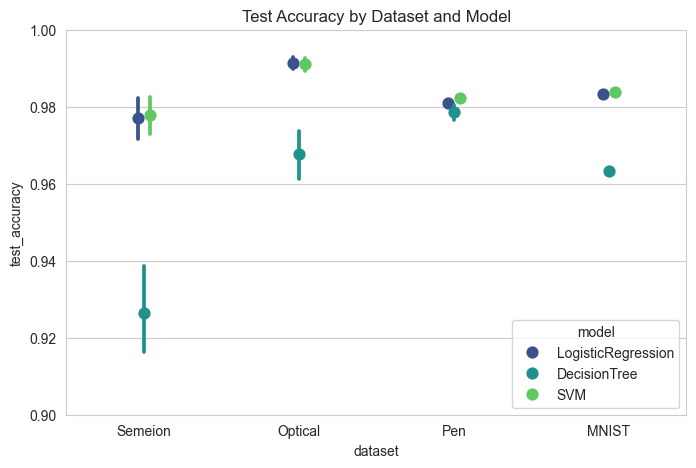

In [50]:
save_dir = "../results/plots"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(8,5))
'''
sns.barplot(data=df, x='dataset', y='test_accuracy', hue='model', palette='viridis')
plt.title("Test Accuracy by Dataset and Model")
plt.ylabel("Test Accuracy")
plt.show()
'''

sns.pointplot(
    data=df,
    x='dataset',
    y='test_accuracy',
    hue='model',
    palette='viridis',
    dodge=True,
    markers='o',
    linestyles=''
)
plt.ylim(0.9, 1.0)
plt.title("Test Accuracy by Dataset and Model")
filename = "accuracy_dataset_model.png"
plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
plt.show()
plt.close()